In [1]:
import importlib
 
if importlib.util.find_spec('fsspec') is None:
  !pip install fsspec
if importlib.util.find_spec('s3fs') is None:
  !pip install s3fs

     |████████████████████████████████| 92kB 5.7MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 1.3MB 11.4MB/s 
     |████████████████████████████████| 6.5MB 19.0MB/s 
     |████████████████████████████████| 296kB 48.6MB/s 
     |████████████████████████████████| 143kB 50.6MB/s 
     |████████████████████████████████| 552kB 49.6MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3162 sha256=9c8e95d98f3411ae6bf5241cd34ae095eeb2c7e31962306ce5aee1e5d596a7fc
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: docutils 0.16
    Uninstalling docutils-0.16:
      Successfully uninstalled docutils-0.16


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

Read the data

In [3]:
#read csv file
df = pd.read_csv('s3://lfspf/Portfolio.csv',parse_dates=True,index_col='T')

Keep only the returns of the indices

In [4]:
df= df.loc[:,['DAX', 'NKY', 'SPX', 'SX5E', 'SX7E', 'SXAP', 'SXKP']].copy()
names = df.columns

Define the buckets for which we want to calculate the volatility 

In [5]:
buckets = [5,10,20,30,60,90]

As an example calculate the 10D and 30D rolling volatility of the DAX index

In [6]:
df['dax_10'] = df['DAX'].rolling(window=10).apply(lambda x : 100*np.std(x)*np.sqrt(250),raw=True)
df['dax_30'] = df['DAX'].rolling(window=30).apply(lambda x : 100*np.std(x)*np.sqrt(250),raw=True)


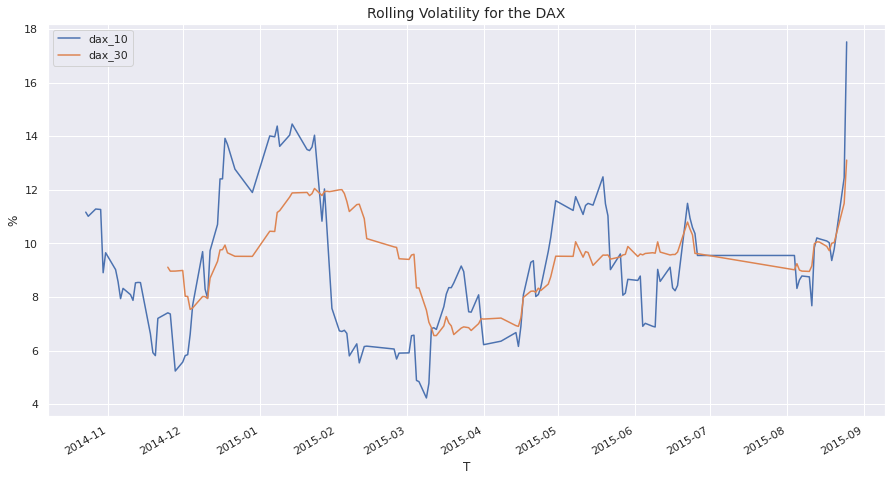

In [7]:

ax=df.loc[:,['dax_10','dax_30']].plot(figsize=(15,8))
ax.set_ylabel('%');
ax.set_title('Rolling Volatility for the DAX',fontsize=14);

Each of these volatilties have properties: max, min, 75% percentile, etc...

In [8]:
df[['dax_10','dax_30']].describe()

,dax_10,dax_30
count,147.000000,127.000000
mean,8.980769,9.372051
std,2.514789,1.543128
min,4.229339,6.558162
25%,6.905383,8.230936
50%,8.544121,9.566216
75%,10.651494,10.055666
max,17.525766,13.111181


The program below produces these data to generate a volatility cone

In [9]:
df_cone = pd.DataFrame()

for c in names:
    for b in buckets:
        vol = dict()
        y = df[c].rolling(window=b).apply(lambda x : 100*np.std(x)*np.sqrt(250),raw=True).describe()
        vol['name']=c
        vol['bucket']=b
        vol['max']=y['max']
        vol['min']=y['min']
        vol['mean']=y['mean']
        vol['75%']=y['75%']
        vol['25%']=y['25%']
        
        df_cone = pd.concat([df_cone,pd.DataFrame.from_dict(vol,orient='index').T],axis=0)
        
        

In [10]:
df_cone.head(10)

,name,bucket,max,min,mean,75%,25%
0,DAX,5,22.2769,2.57637,8.49176,10.4515,6.07415
0,DAX,10,17.5258,4.22934,8.98077,10.6515,6.90538
0,DAX,20,14.9054,5.31346,9.26354,10.5342,7.62545
0,DAX,30,13.1112,6.55816,9.37205,10.0557,8.23094
0,DAX,60,11.5049,8.37411,9.42378,9.74935,8.96085
0,DAX,90,10.4394,8.69819,9.41799,9.75354,9.1063
0,NKY,5,17.6881,0.94881,6.35768,7.68493,3.97887
0,NKY,10,14.0958,2.01365,6.9711,8.53794,5.16513
0,NKY,20,13.2219,4.25818,7.18699,8.10579,5.68934
0,NKY,30,12.0672,4.91622,7.13419,8.4559,5.71115


In [11]:
idx = df_cone['name']=='DAX'
df_DAX = df_cone.loc[idx,:].copy()

In [12]:
df_DAX.index = df_DAX['bucket']

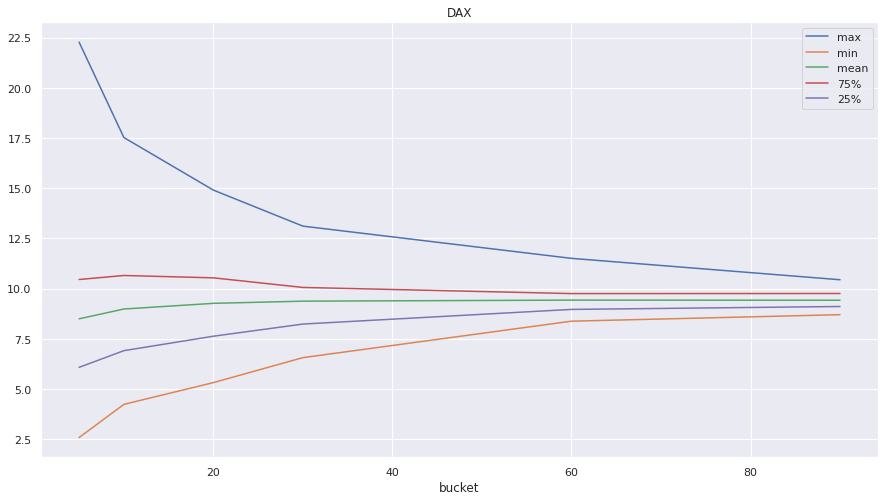

In [13]:
df_DAX[['max','min','mean','75%','25%']].plot(figsize=(15,8),title='DAX');